In [30]:
import torch # Import the PyTorch library for building neural networks
import torch.nn as nn # Import the neural network module from PyTorch

class MNISTModelFinal(nn.Module):
    """Your model with configurable dropout rates"""
    # This class defines a convolutional neural network (CNN) for MNIST digit classification.
    # It inherits from nn.Module, the base class for all neural network modules in PyTorch.
    def __init__(self):
        # Call the constructor of the parent class (nn.Module)
        super(MNISTModelFinal, self).__init__()

        # Define the convolutional layers using nn.Sequential
        # nn.Sequential is a container that holds a sequence of modules.
        # The input will be passed through all modules in the same order as they are added.
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),

            nn.Conv2d(12, 12, kernel_size=3, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(12, 12, kernel_size=3, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),


            nn.Conv2d(12, 12, kernel_size=3, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(12, 24, kernel_size=3, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d(1),

            nn.Conv2d(24, 10, kernel_size=1, bias=False),

        )


    def forward(self, x):
        x = self.conv1(x)              # Shape: [batch, 10, 14, 14]
        x = x.view(-1, 10)
        return x

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import time
from torch.optim.lr_scheduler import StepLR
import os # Import the os module for interacting with the operating system

def load_mnist_data(batch_size=64):
    """Load and preprocess MNIST dataset with affine translate augmentation"""
    # Data transformations for training with augmentation
    transform_train = transforms.Compose([
        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Download and load datasets
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, test_loader

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100. * correct / total:.2f}%'
        })

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def test_epoch(model, test_loader, criterion, device):
    """Test model"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Testing')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100. * correct / total:.2f}%'
            })

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def count_parameters(model):
    """Count trainable parameters in the model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def main(model):
    # Training configuration
    config = {
        'batch_size': 32,
        'epochs': 15,
        'lr': 0.001,
        'weight_decay': 0.0001,
        'scheduler': 'plateau',
        'patience': 3,
        'factor': 0.5,
        'min_lr': 1e-6,
        'dropout': (0.05, 0.05, 0.05)
    }


    print("="*60)
    print("MNIST Training Configuration")
    print("="*60)
    for key, value in config.items():
        print(f"{key}: {value}")
    print("="*60)

    # Load data
    print("\nLoading MNIST dataset...")
    train_loader, test_loader = load_mnist_data(config['batch_size'])
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")


    # Print model summary
    print("\n" + "="*60)
    print("MODEL ARCHITECTURE SUMMARY")
    print("="*60)
    print(f"Model parameters: {count_parameters(model):,}")
    print(f"Dropout rates: {config['dropout']}")
    print("\nDetailed Model Summary:")
    try:
        summary(model, (1, 28, 28))
    except:
        print("torchsummary not available, showing model structure:")
        print(model)

    # Initialize optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=config['factor'],
        patience=config['patience'],
        min_lr=config['min_lr']
    )

    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

    criterion = nn.CrossEntropyLoss()

    # Training history
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    learning_rates = []

    print("\n" + "="*60)
    print("TRAINING STARTED")
    print("="*60)

    start_time = time.time()

    for epoch in range(config['epochs']):
        print(f"\nEpoch [{epoch+1}/{config['epochs']}]")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Test
        test_loss, test_acc = test_epoch(model, test_loader, criterion, device)

        # Update scheduler
        scheduler.step(test_loss)

        # Store history
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch summary
        print("\n" + "-"*50)
        print("EPOCH SUMMARY")
        print("-"*50)
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-"*50)

    # Final results
    total_time = time.time() - start_time
    print("\n" + "="*60)
    print("TRAINING COMPLETED")
    print("="*60)
    print(f"Total training time: {total_time:.2f} seconds")
    print(f"Best train accuracy: {max(train_accuracies):.2f}%")
    print(f"Best test accuracy: {max(test_accuracies):.2f}%")
    print(f"Final train accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Final test accuracy: {test_accuracies[-1]:.2f}%")

    return model, train_accuracies, test_accuracies


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MNISTModelFinal().to(device)

trained_model, train_acc, test_acc = main(model)

MNIST Training Configuration
batch_size: 32
epochs: 15
lr: 0.001
weight_decay: 0.0001
scheduler: plateau
patience: 3
factor: 0.5
min_lr: 1e-06
dropout: (0.05, 0.05, 0.05)

Loading MNIST dataset...
Train samples: 60000
Test samples: 10000

MODEL ARCHITECTURE SUMMARY
Model parameters: 6,972
Dropout rates: (0.05, 0.05, 0.05)

Detailed Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,296
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
         MaxPool2d-7           [-1, 12, 12, 12]               0
            Conv2d-8           [-1, 12, 10, 10]           1,296
       Bat

Testing: 100%|██████████| 313/313 [00:01<00:00, 262.34it/s, Loss=0.0106, Acc=98.57%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.2759 | Train Acc: 94.54%
Test Loss:  0.0522 | Test Acc:  98.57%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [2/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 254.89it/s, Loss=0.0026, Acc=98.82%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0627 | Train Acc: 98.19%
Test Loss:  0.0350 | Test Acc:  98.82%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [3/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 261.53it/s, Loss=0.0043, Acc=98.80%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0487 | Train Acc: 98.48%
Test Loss:  0.0398 | Test Acc:  98.80%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [4/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 256.80it/s, Loss=0.0032, Acc=99.12%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0424 | Train Acc: 98.65%
Test Loss:  0.0270 | Test Acc:  99.12%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [5/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 260.86it/s, Loss=0.0006, Acc=99.19%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0392 | Train Acc: 98.78%
Test Loss:  0.0255 | Test Acc:  99.19%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [6/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 260.22it/s, Loss=0.0003, Acc=99.23%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0385 | Train Acc: 98.74%
Test Loss:  0.0250 | Test Acc:  99.23%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [7/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 255.92it/s, Loss=0.0012, Acc=99.31%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0352 | Train Acc: 98.87%
Test Loss:  0.0214 | Test Acc:  99.31%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [8/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 260.82it/s, Loss=0.0003, Acc=99.42%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0330 | Train Acc: 98.95%
Test Loss:  0.0215 | Test Acc:  99.42%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [9/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 260.16it/s, Loss=0.0002, Acc=99.40%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0311 | Train Acc: 99.02%
Test Loss:  0.0198 | Test Acc:  99.40%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [10/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 259.30it/s, Loss=0.0004, Acc=99.36%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0291 | Train Acc: 99.06%
Test Loss:  0.0228 | Test Acc:  99.36%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [11/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 259.00it/s, Loss=0.0006, Acc=99.34%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0276 | Train Acc: 99.13%
Test Loss:  0.0222 | Test Acc:  99.34%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [12/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 260.34it/s, Loss=0.0002, Acc=99.36%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0275 | Train Acc: 99.15%
Test Loss:  0.0218 | Test Acc:  99.36%
Learning Rate: 0.001000
--------------------------------------------------

Epoch [13/15]
Learning Rate: 0.001000


Testing: 100%|██████████| 313/313 [00:01<00:00, 260.29it/s, Loss=0.0003, Acc=99.24%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0272 | Train Acc: 99.14%
Test Loss:  0.0241 | Test Acc:  99.24%
Learning Rate: 0.000500
--------------------------------------------------

Epoch [14/15]
Learning Rate: 0.000500


Testing: 100%|██████████| 313/313 [00:01<00:00, 259.17it/s, Loss=0.0001, Acc=99.46%]



--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0207 | Train Acc: 99.33%
Test Loss:  0.0177 | Test Acc:  99.46%
Learning Rate: 0.000500
--------------------------------------------------

Epoch [15/15]
Learning Rate: 0.000500


Testing: 100%|██████████| 313/313 [00:01<00:00, 260.31it/s, Loss=0.0001, Acc=99.40%]


--------------------------------------------------
EPOCH SUMMARY
--------------------------------------------------
Train Loss: 0.0202 | Train Acc: 99.35%
Test Loss:  0.0184 | Test Acc:  99.40%
Learning Rate: 0.000500
--------------------------------------------------

TRAINING COMPLETED
Total training time: 416.14 seconds
Best train accuracy: 99.35%
Best test accuracy: 99.46%
Final train accuracy: 99.35%
Final test accuracy: 99.40%


Original image shape: torch.Size([1, 28, 28]), Label: 1


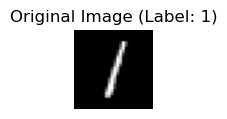

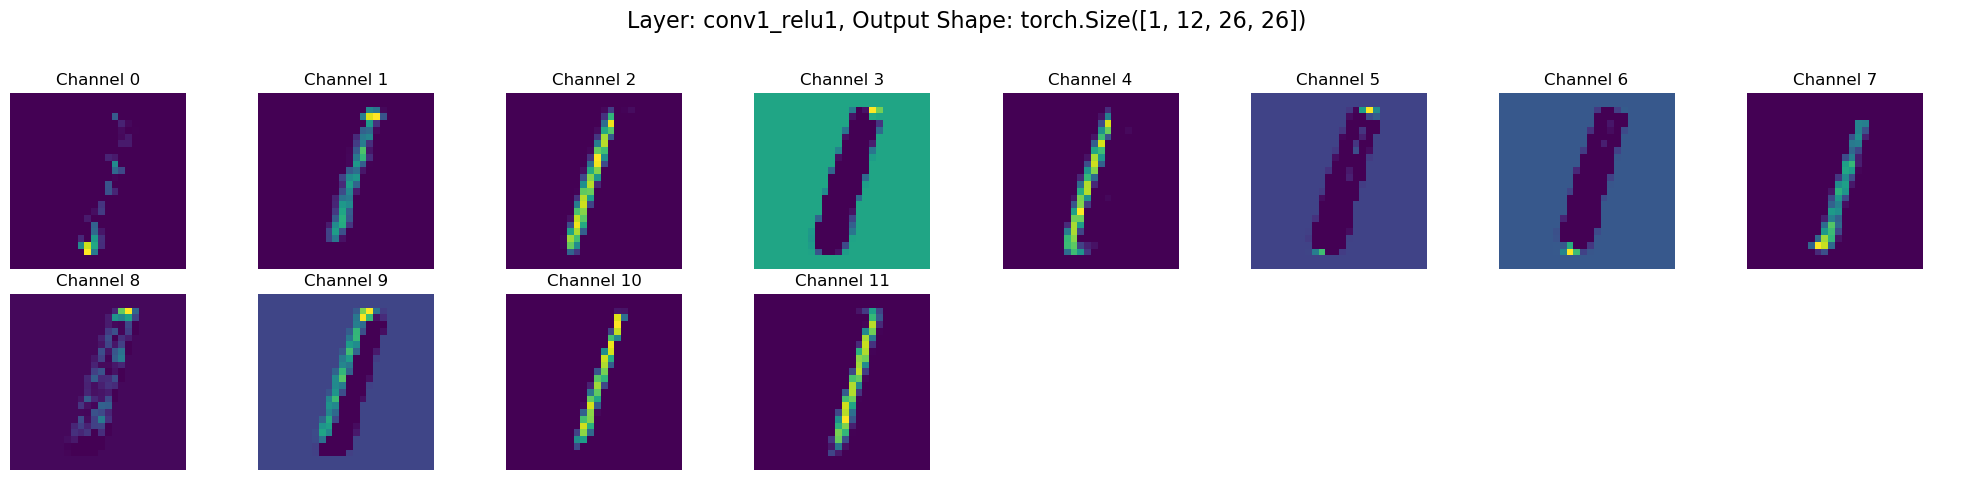

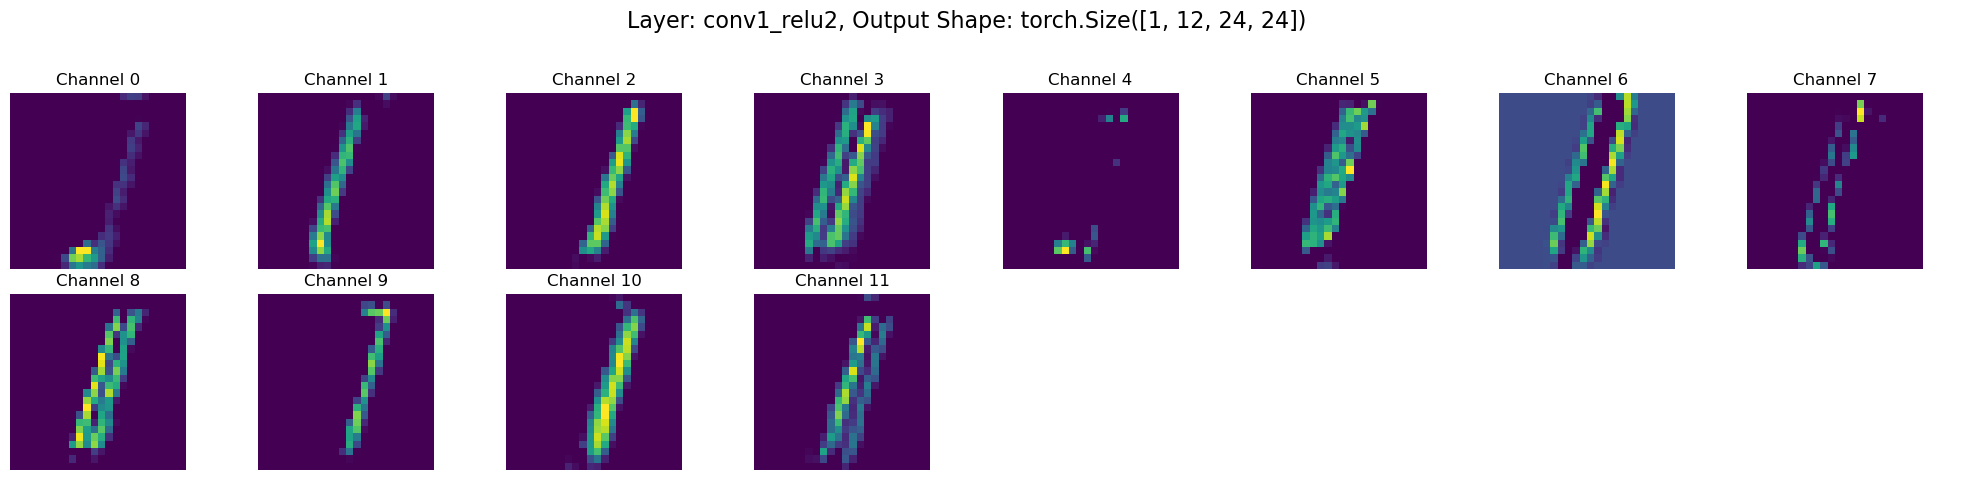

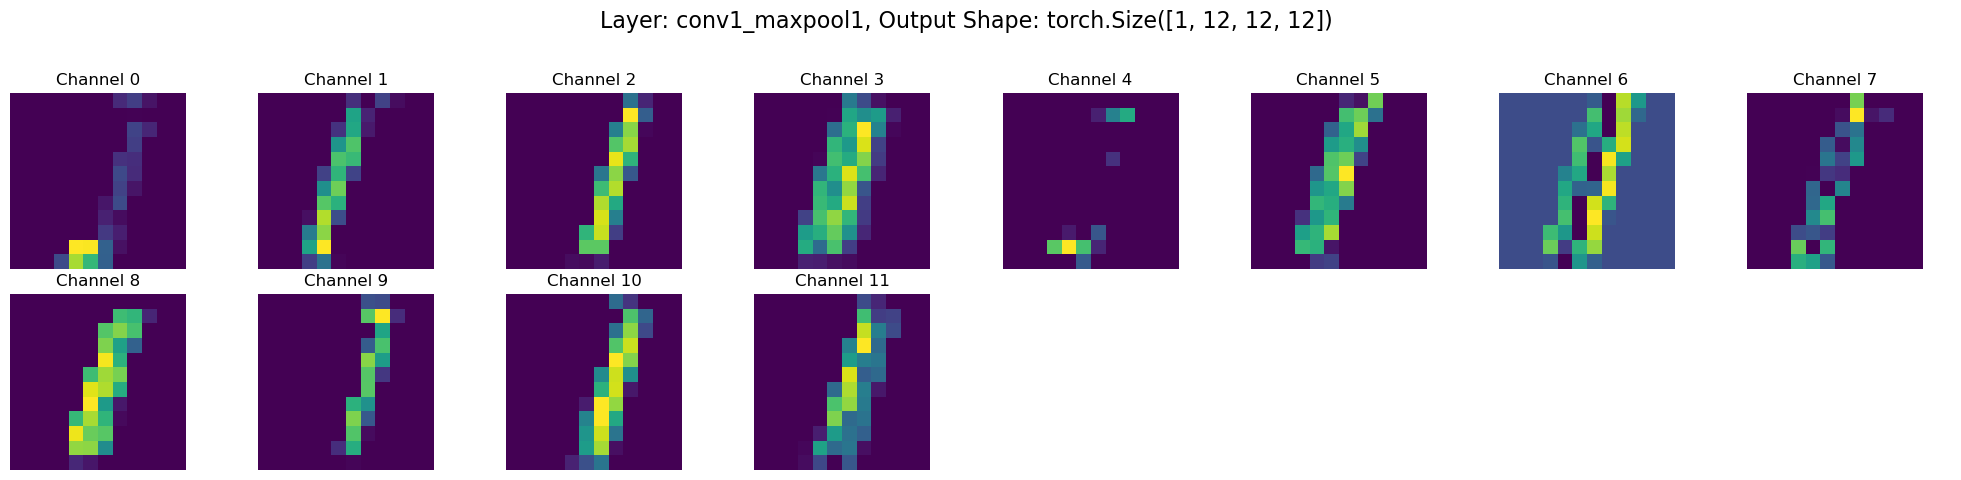

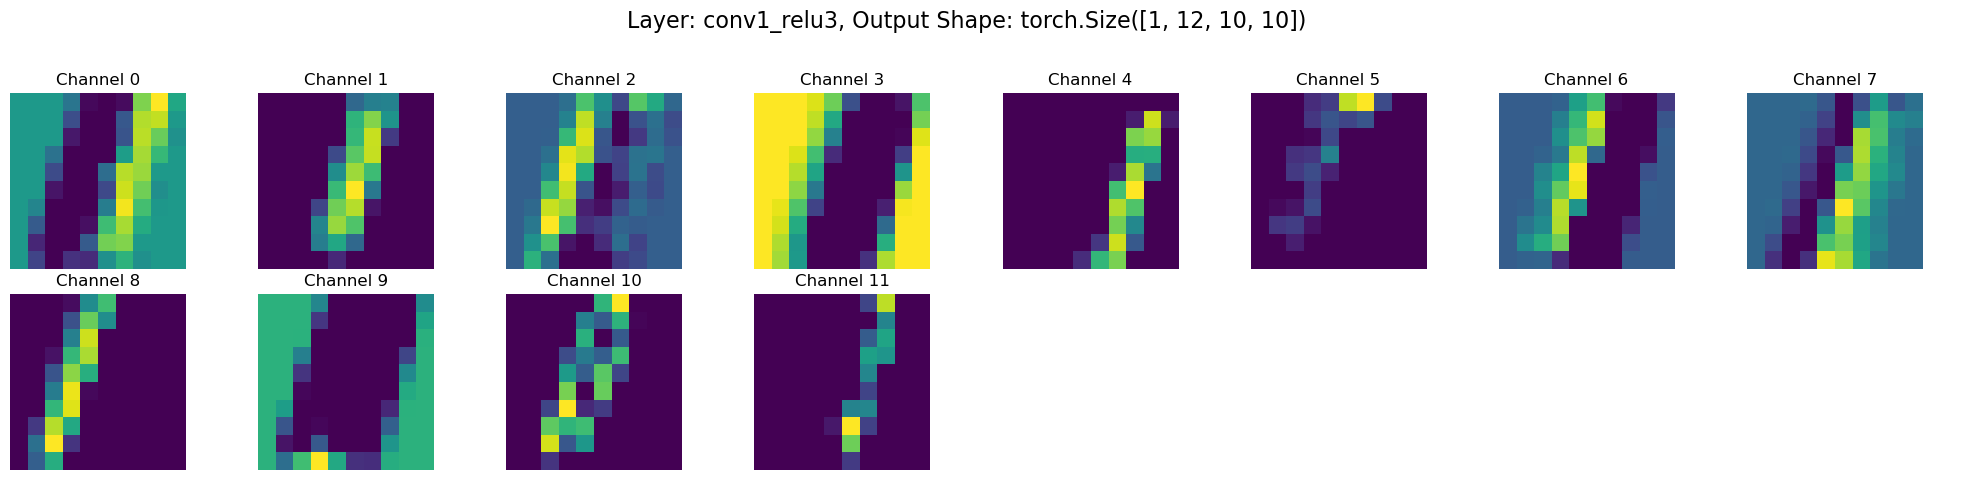

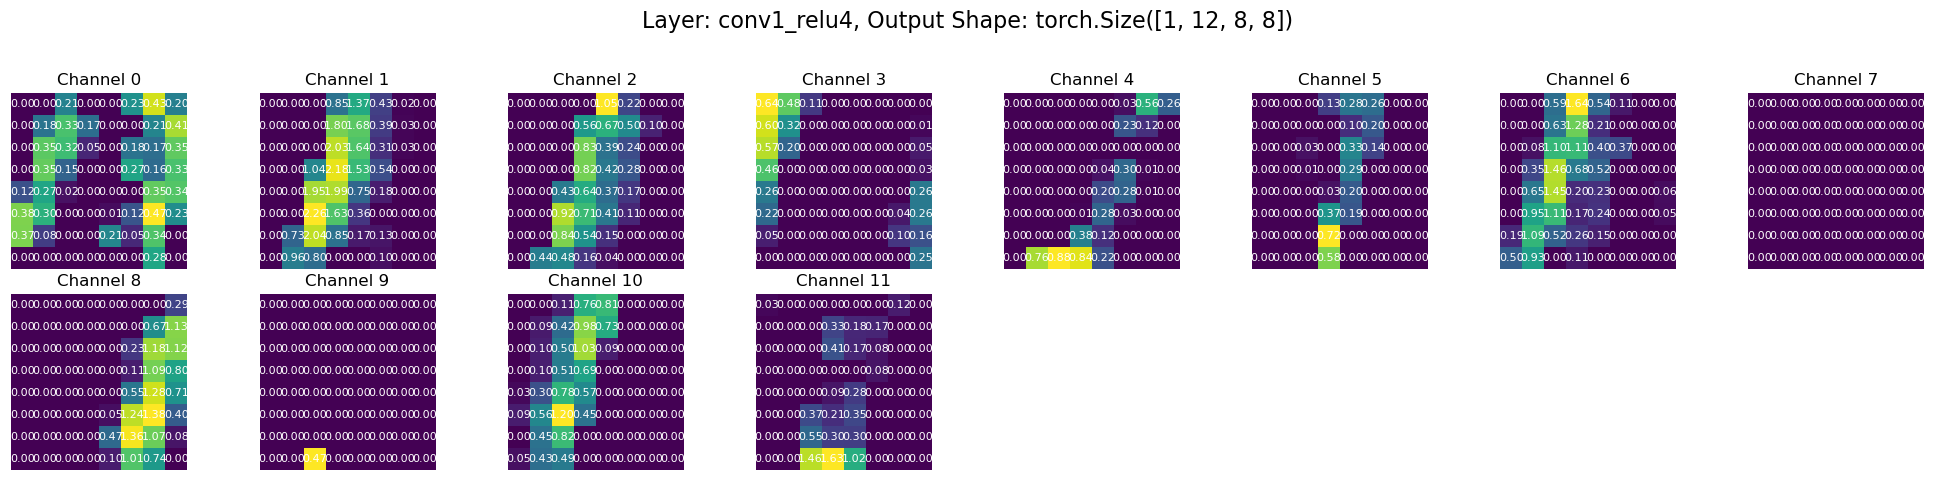

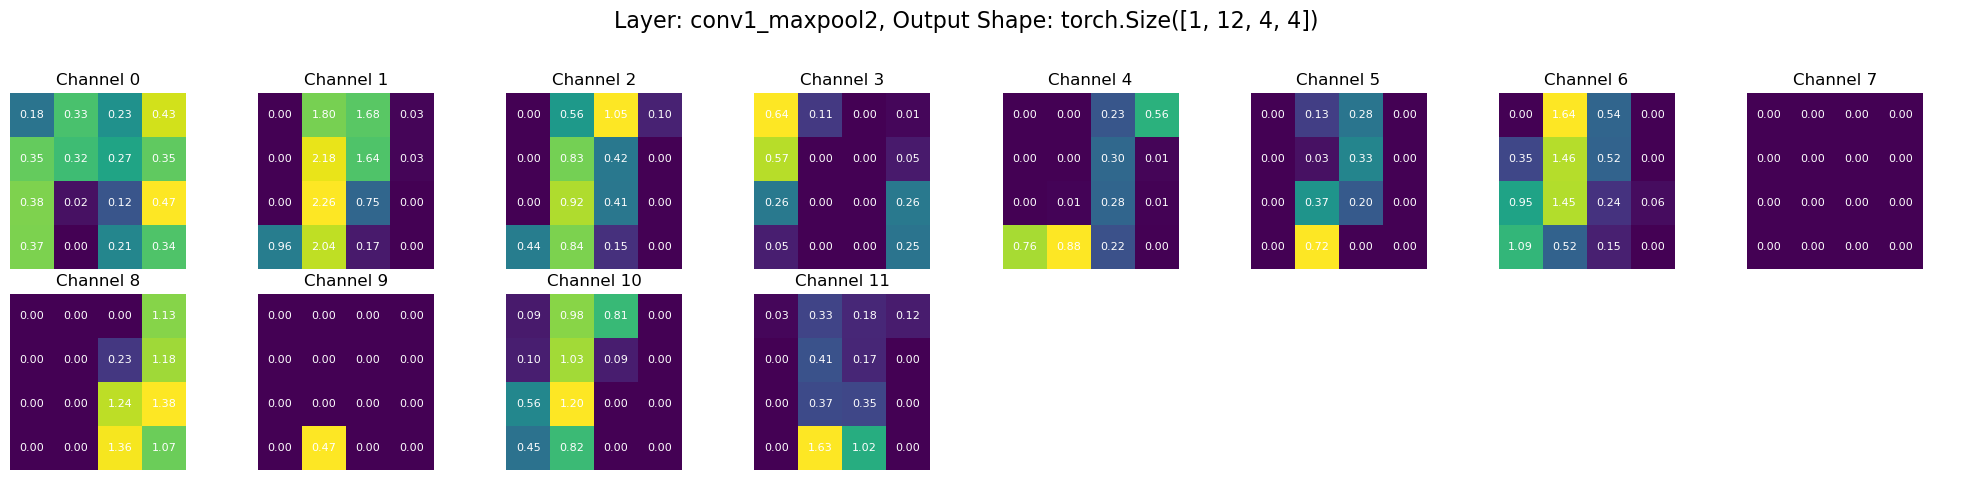

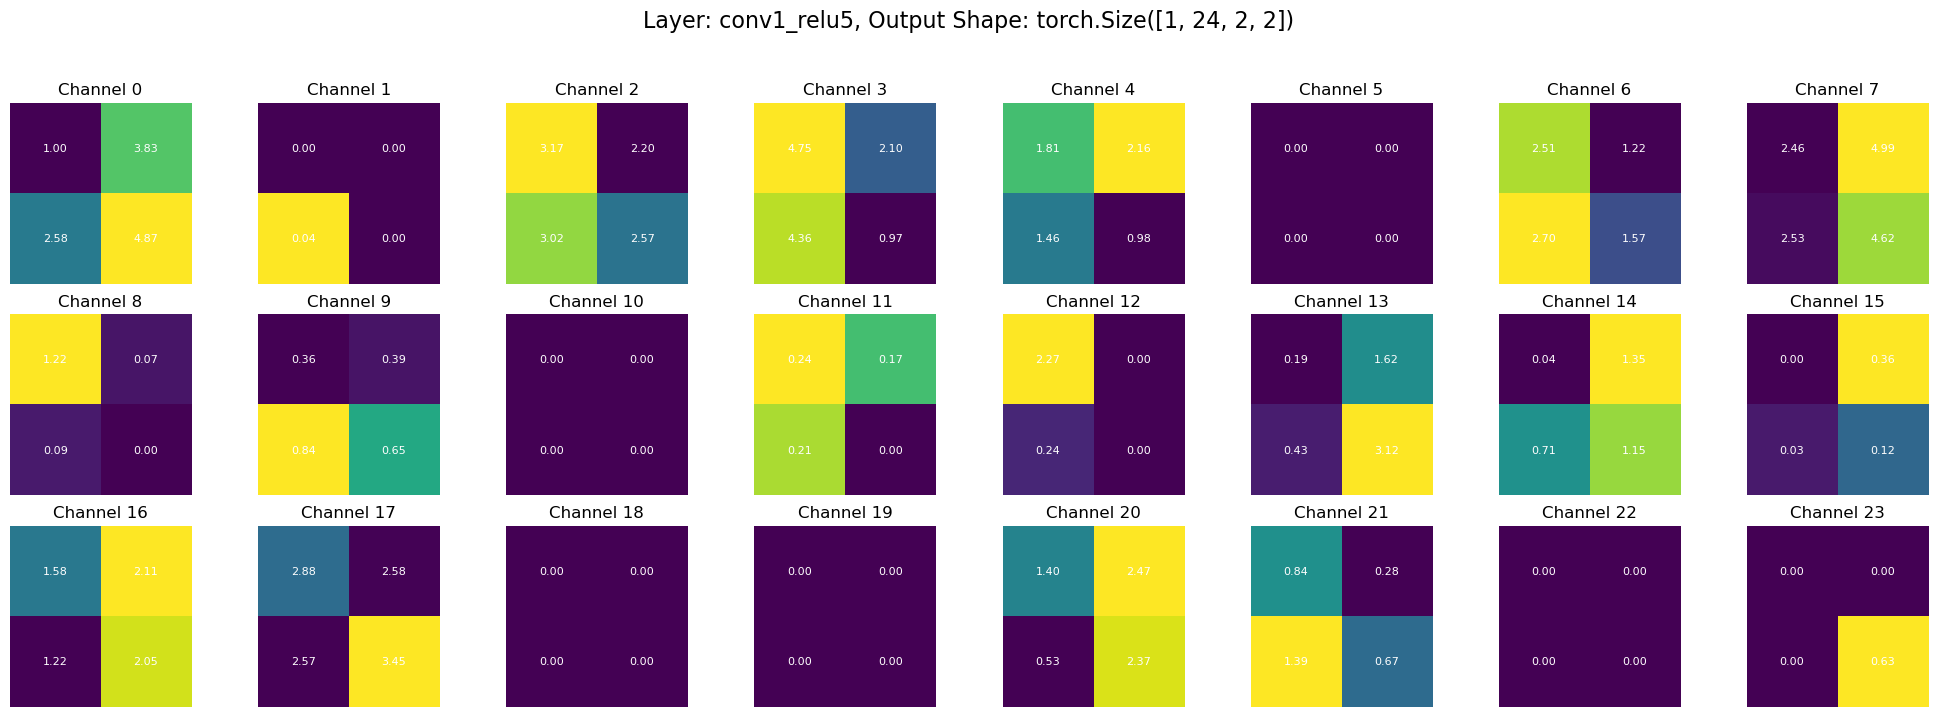

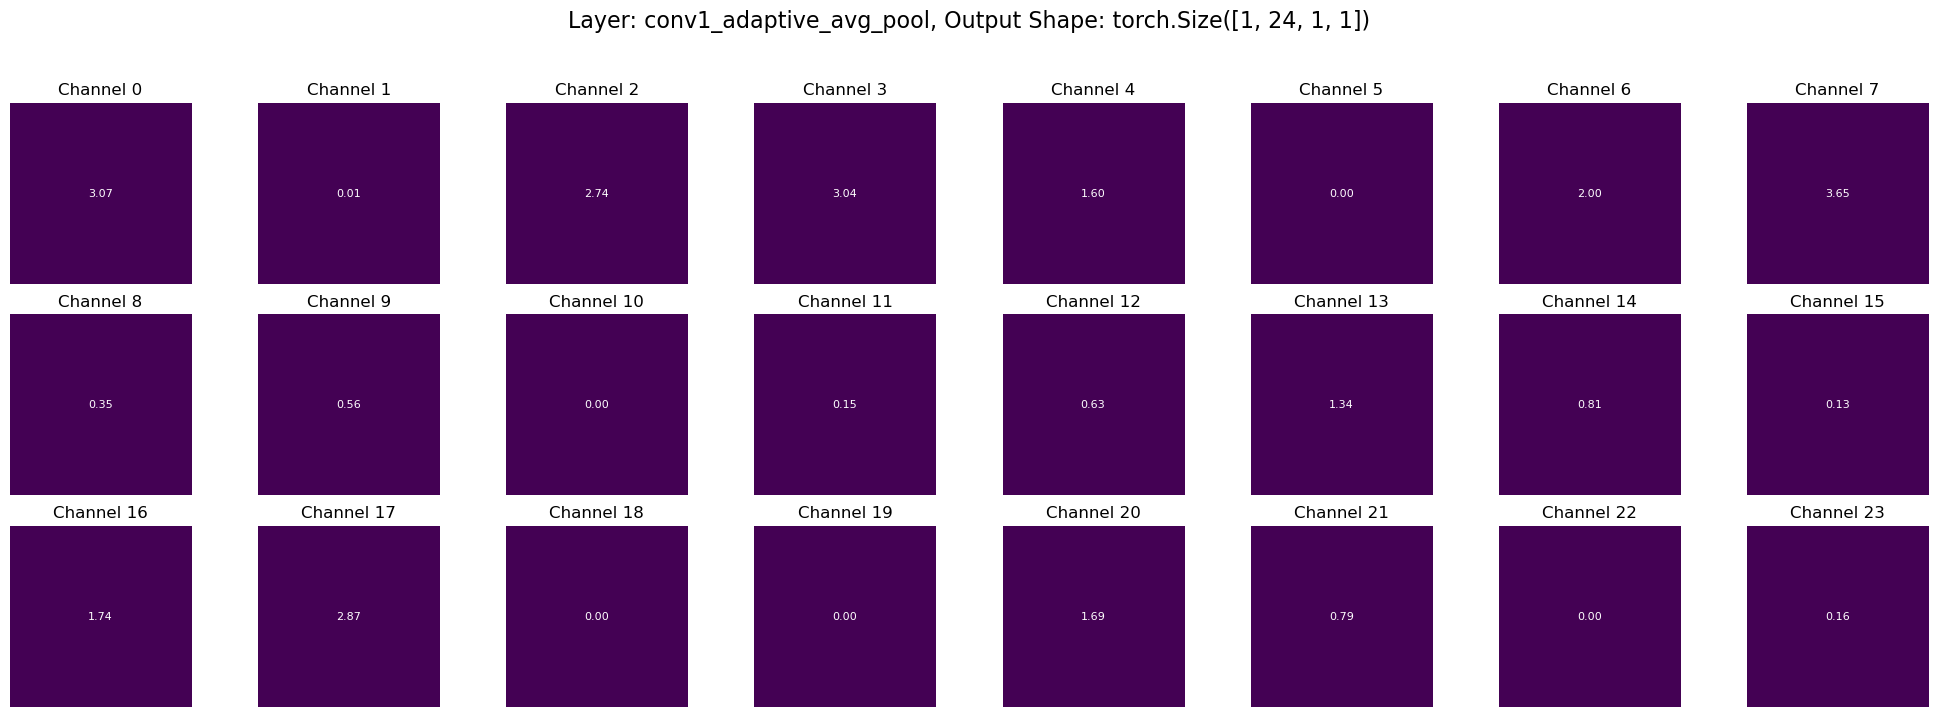

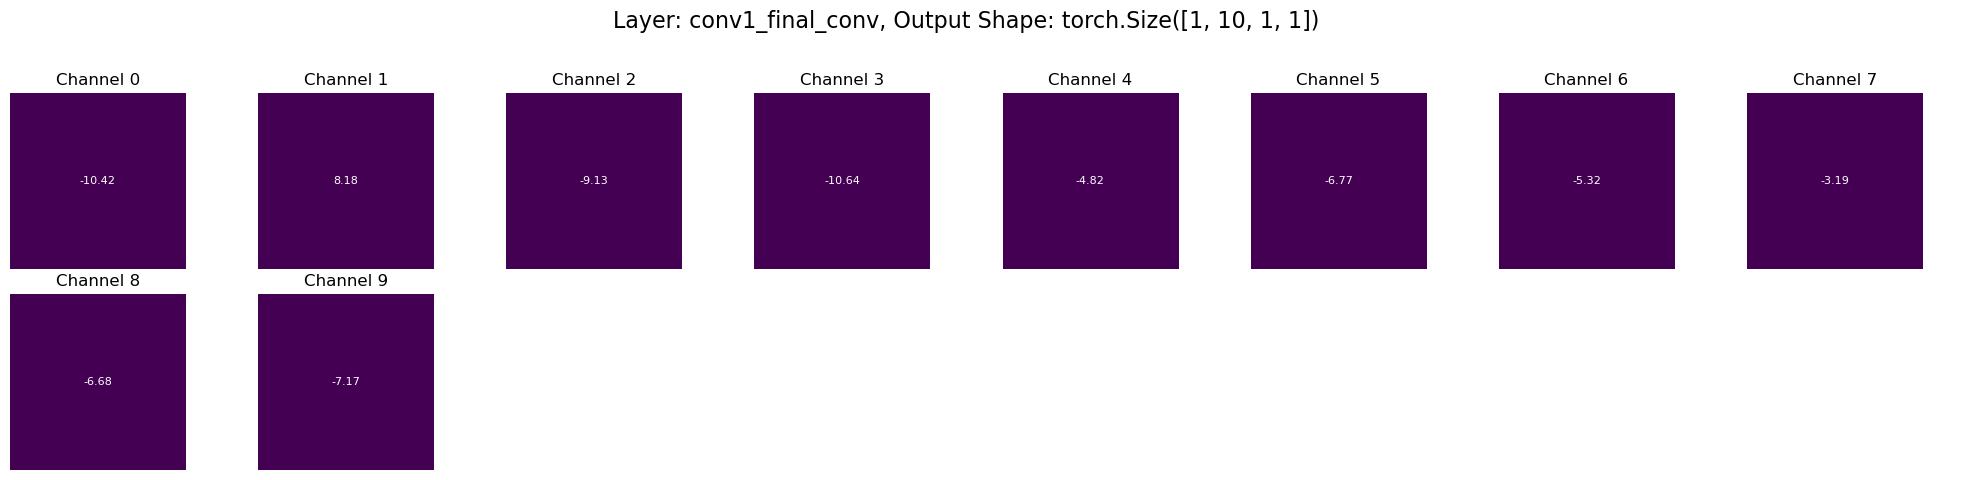

Visualization complete.


In [32]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


# 1. Load the MNISTModelFinal model
model = trained_model
# It's good practice to load trained weights if available, but for visualization of architecture, random weights are fine.
# If you have a checkpoint, you can load it:
# model.load_state_dict(torch.load('model3/mnist_model_checkpoint.pth')['model_state_dict'])
model.eval() # Set model to evaluation mode

# 2. Load a single image from the MNIST dataset
# We need to use the same transformations as during training, but for visualization of raw image, we'll get one without normalization first
transform_raw = transforms.Compose([
    transforms.ToTensor(),
])

transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset_raw = datasets.MNIST(root='./data', train=False, download=True, transform=transform_raw)
test_dataset_normalized = datasets.MNIST(root='./data', train=False, download=True, transform=transform_normalized)

# Select a single image
image_raw, label = test_dataset_raw[2] # Get the first image and its label
image_normalized, _ = test_dataset_normalized[2] # Get the normalized version

print(f"Original image shape: {image_raw.shape}, Label: {label}")

# Add a batch dimension
image_normalized = image_normalized.unsqueeze(0) # Shape: [1, 1, 28, 28]

# 3. Implement forward hooks to capture outputs from each significant layer
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks for the layers within the conv1 sequential block
# The sequential block is at model.conv1
# Accessing individual modules in nn.Sequential: model.conv1[idx]

# I will choose to hook after each ReLU and MaxPool2d to see the feature evolution.
# Looking at model3.py lines:
# 15: self.conv1 = nn.Sequential(
# 17:    nn.Conv2d(1, 12, kernel_size=3, padding='same', bias=False),
# 18:    nn.BatchNorm2d(12),
# 19:    nn.ReLU(inplace=True), # Hook 1 (idx 2) - after first conv block
# 23:    nn.Conv2d(12, 12, kernel_size=3, padding='same', groups=1, bias=False),
# 24:    nn.BatchNorm2d(12),
# 25:    nn.ReLU(inplace=True), # Hook 2 (idx 5) - after second conv block
# 28:    nn.MaxPool2d(kernel_size=2), # Hook 3 (idx 6) - after first maxpool
# 32:    nn.Conv2d(12, 12, kernel_size=3, padding='same', bias=False),
# 33:    nn.BatchNorm2d(12),
# 34:    nn.ReLU(inplace=True), # Hook 4 (idx 9) - after third conv block
# 38:    nn.Conv2d(12, 12, kernel_size=3, padding='same', bias=False),
# 39:    nn.BatchNorm2d(12),
# 40:    nn.ReLU(inplace=True), # Hook 5 (idx 12) - after fourth conv block
# 43:    nn.MaxPool2d(kernel_size=2), # Hook 6 (idx 13) - after second maxpool
# 46:    nn.Conv2d(12, 24, kernel_size=3, groups=4, bias=False),
# 47:    nn.BatchNorm2d(24),
# 48:    nn.ReLU(inplace=True), # Hook 7 (idx 16) - after fifth conv block
# 51:    nn.AdaptiveAvgPool2d(1), # Hook 8 (idx 17) - after adaptive avg pool
# 54:    nn.Conv2d(24, 10, kernel_size=1, bias=False), # Hook 9 (idx 18) - after final 1x1 conv
# )

model.conv1[2].register_forward_hook(get_activation('conv1_relu1'))
model.conv1[5].register_forward_hook(get_activation('conv1_relu2'))
model.conv1[6].register_forward_hook(get_activation('conv1_maxpool1'))
model.conv1[9].register_forward_hook(get_activation('conv1_relu3'))
model.conv1[12].register_forward_hook(get_activation('conv1_relu4'))
model.conv1[13].register_forward_hook(get_activation('conv1_maxpool2'))
model.conv1[16].register_forward_hook(get_activation('conv1_relu5'))
model.conv1[17].register_forward_hook(get_activation('conv1_adaptive_avg_pool'))
model.conv1[18].register_forward_hook(get_activation('conv1_final_conv'))


# 4. Perform a forward pass on the selected image
with torch.no_grad():
    output = model(image_normalized)

# 5. Plot the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, len(activations) + 1, 1) # +1 for the original image
plt.imshow(image_raw.squeeze().numpy(), cmap='gray')
plt.title(f"Original Image (Label: {label})")
plt.axis('off')

# 6. Plot the feature maps (channels) from selected layers
# I will plot a subset of channels for each layer to avoid too many plots.
# If a layer has many channels, I'll plot the first 8 or so.

plot_idx = 2
for name, activation in activations.items():
    if activation.dim() == 4: # Convolutional/Pooling layers output 4D tensors (batch, channels, height, width)
        num_channels = activation.shape[1]
        # Determine grid dimensions for plotting
        num_cols = 8  # Number of columns for displaying channels
        num_rows = (num_channels + num_cols - 1) // num_cols # Ceiling division

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.5, num_rows * 2.5))
        fig.suptitle(f"Layer: {name}, Output Shape: {activation.shape}", fontsize=16)
        axs = axs.flatten() # Flatten the 2D array of axes for easy iteration

        for i in range(num_channels):
            ax = axs[i]
            channel_data = activation[0, i].cpu().numpy()
            ax.imshow(channel_data, cmap='viridis')
            ax.set_title(f"Channel {i}")
            ax.axis('off')

            # Add numerical values over each pixel if the feature map is small enough
            if channel_data.shape[0] < 10 and channel_data.shape[1] < 10: # Example threshold
                for y in range(channel_data.shape[0]):
                    for x in range(channel_data.shape[1]):
                        ax.text(x, y, f'{channel_data[y, x]:.2f}', ha="center", va="center", color="white", fontsize=8)


        # Turn off any unused subplots
        for i in range(num_channels, num_rows * num_cols):
            axs[i].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif activation.dim() == 2: # Fully connected/output layer
        # For the final 1x1 conv output (logits), it's a 1x10 tensor.
        # We can visualize it as a bar chart or simply print.
        print(f"Layer: {name}, Output Shape: {activation.shape}")
        print(f"Logits: {activation.squeeze().cpu().numpy()}")
        plt.figure(figsize=(8, 2))
        plt.bar(range(activation.shape[1]), activation.squeeze().cpu().numpy())
        plt.title(f"Layer: {name} (Logits)")
        plt.xlabel("Class")
        plt.ylabel("Value")
        plt.xticks(range(activation.shape[1]))
        plt.show()

print("Visualization complete.")



In [ ]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import sys
sys.path.append('.') # Add current directory to path to import model3
from model3 import MNISTModelFinal

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load the MNISTModelFinal model (without training)
# Initialize the model with random weights
model_eval = MNISTModelFinal().to(device)
model_eval.eval() # Set model to evaluation mode

# 2. Load testing data
def load_mnist_data_for_eval(batch_size=64):
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0) # num_workers=0 to avoid Broken Pipe error
    return test_loader

test_loader_eval = load_mnist_data_for_eval(batch_size=64)

# 3. Define an evaluation function (similar to test_epoch from train.py)
def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating Untrained Model')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100. * correct / total:.2f}%'
            })

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# 4. Evaluate the model
print("\n" + "="*60)
print("EVALUATING UNTRAINED MODEL ON TEST DATA")
print("="*60)

test_loss_untrained, test_acc_untrained = evaluate_model(model_eval, test_loader_eval, device)

print("\n" + "-"*50)
print("UNTRAINED MODEL EVALUATION SUMMARY")
print("-"*50)
print(f"Test Loss:  {test_loss_untrained:.4f} | Test Acc:  {test_acc_untrained:.2f}%")
print("-"*50)
print("Untrained model evaluation complete.")



Original image shape: torch.Size([1, 28, 28]), Label: 1


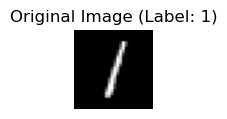

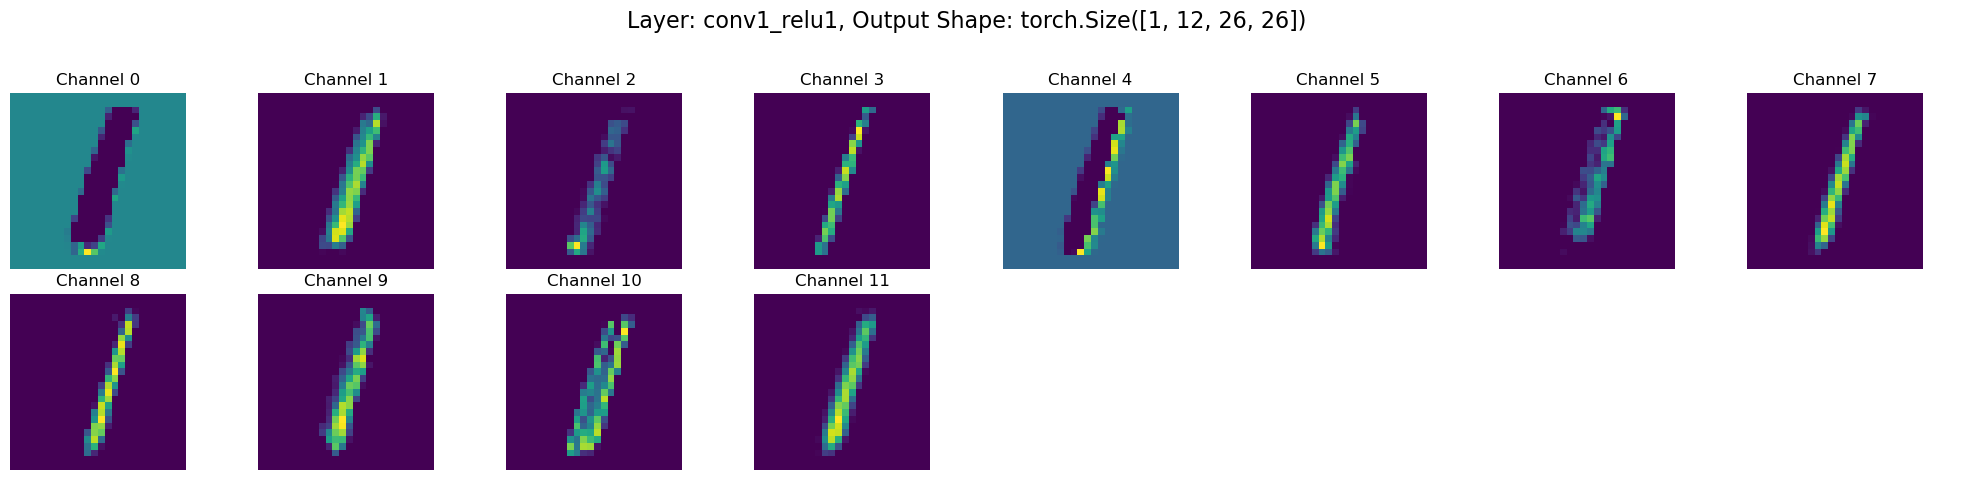

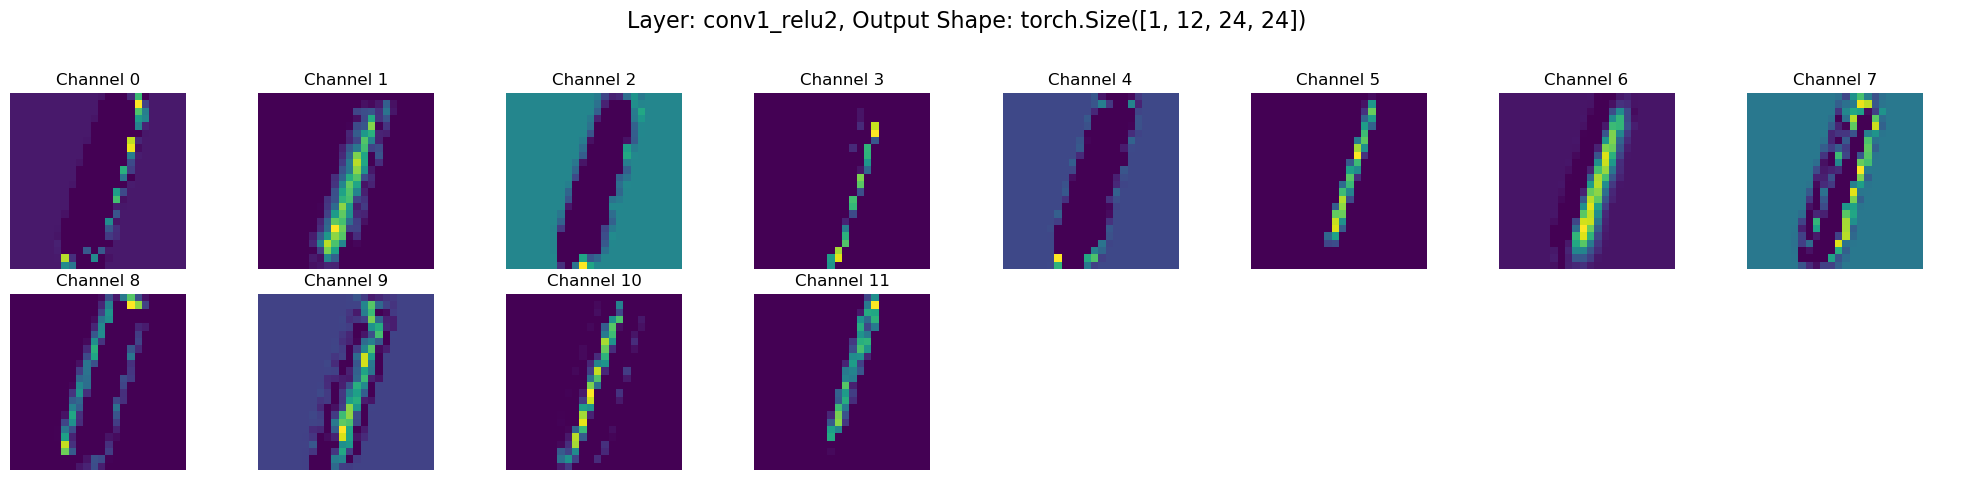

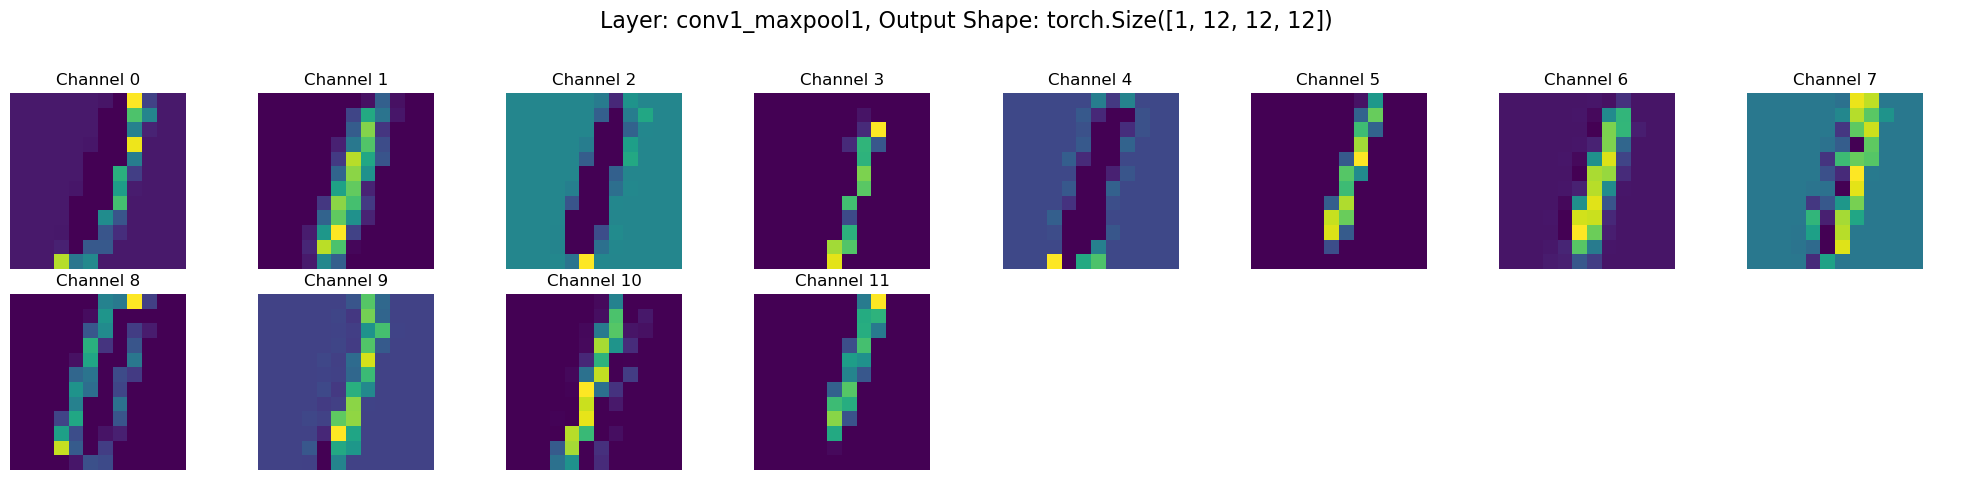

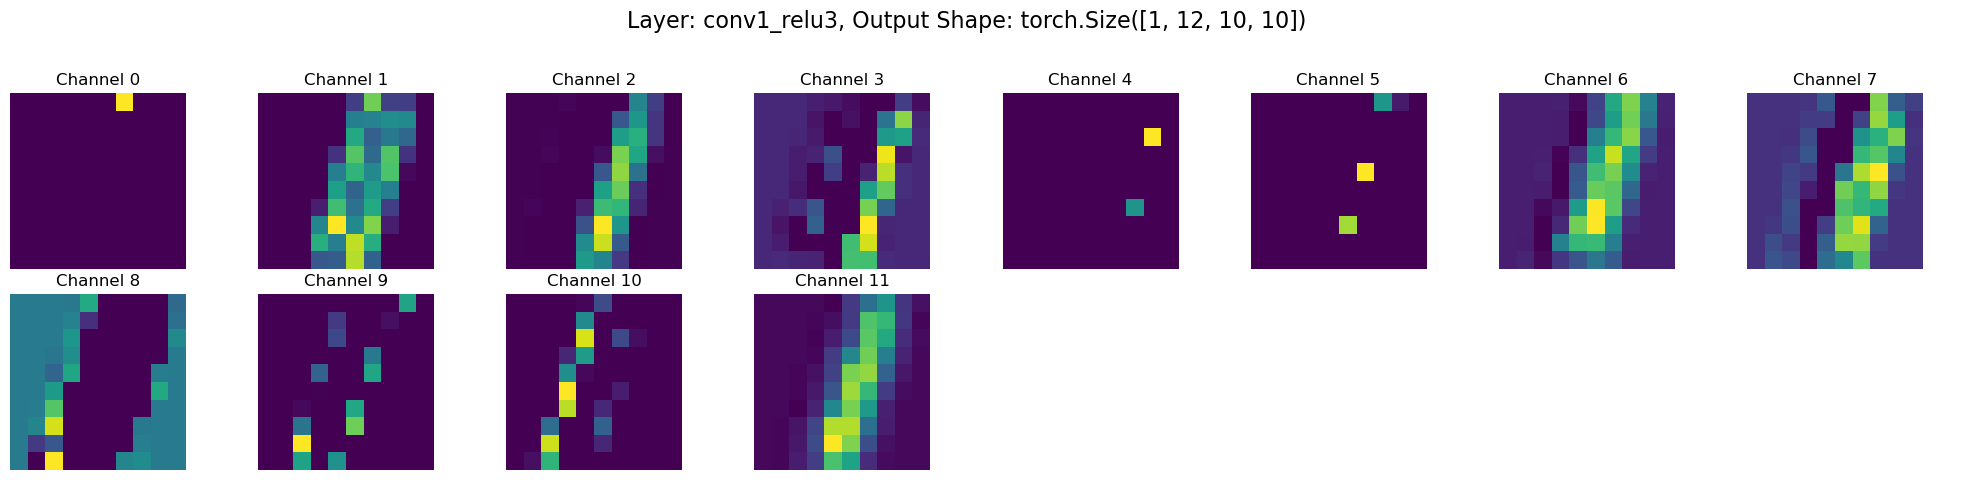

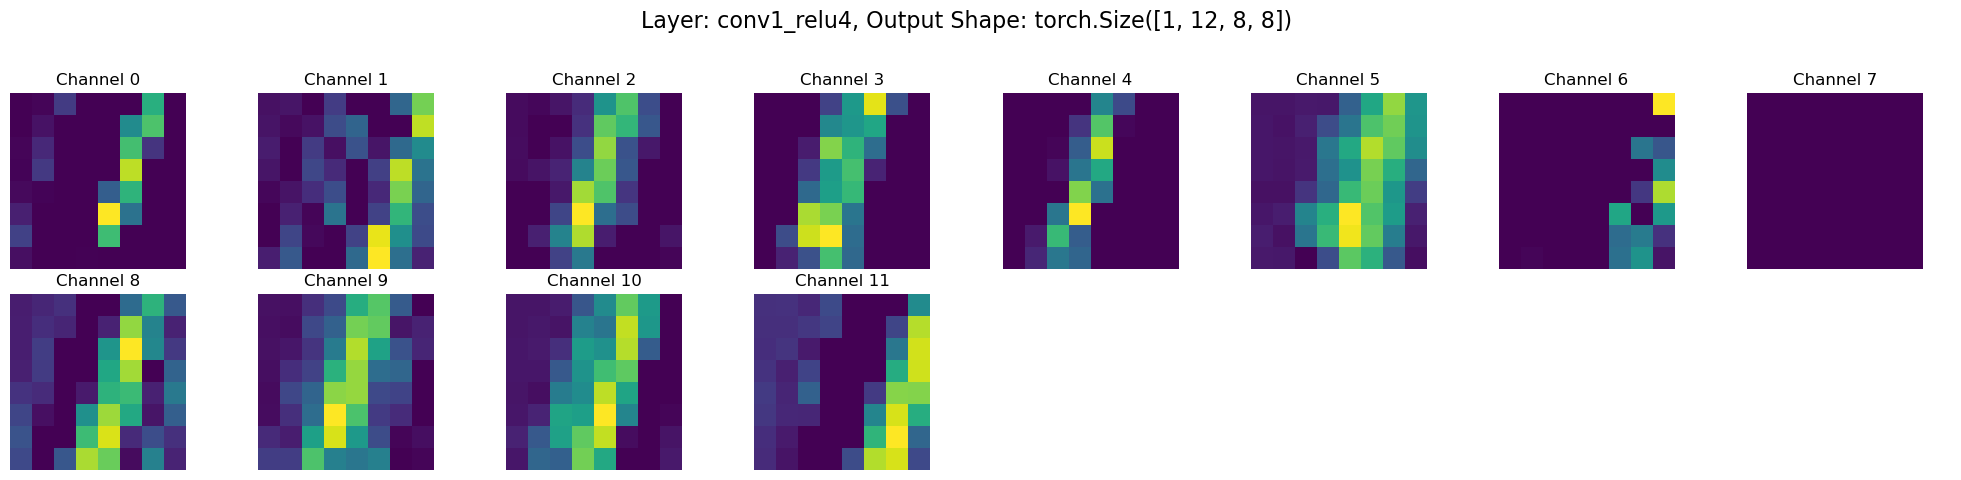

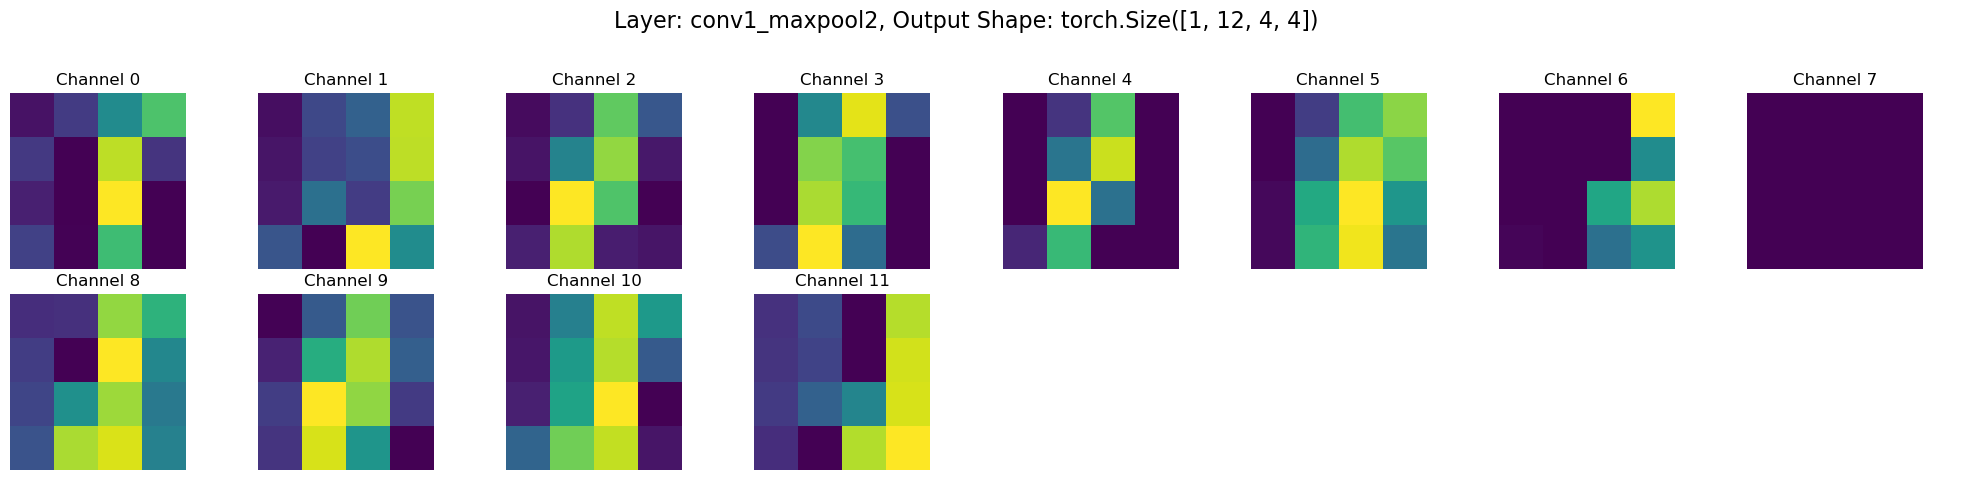

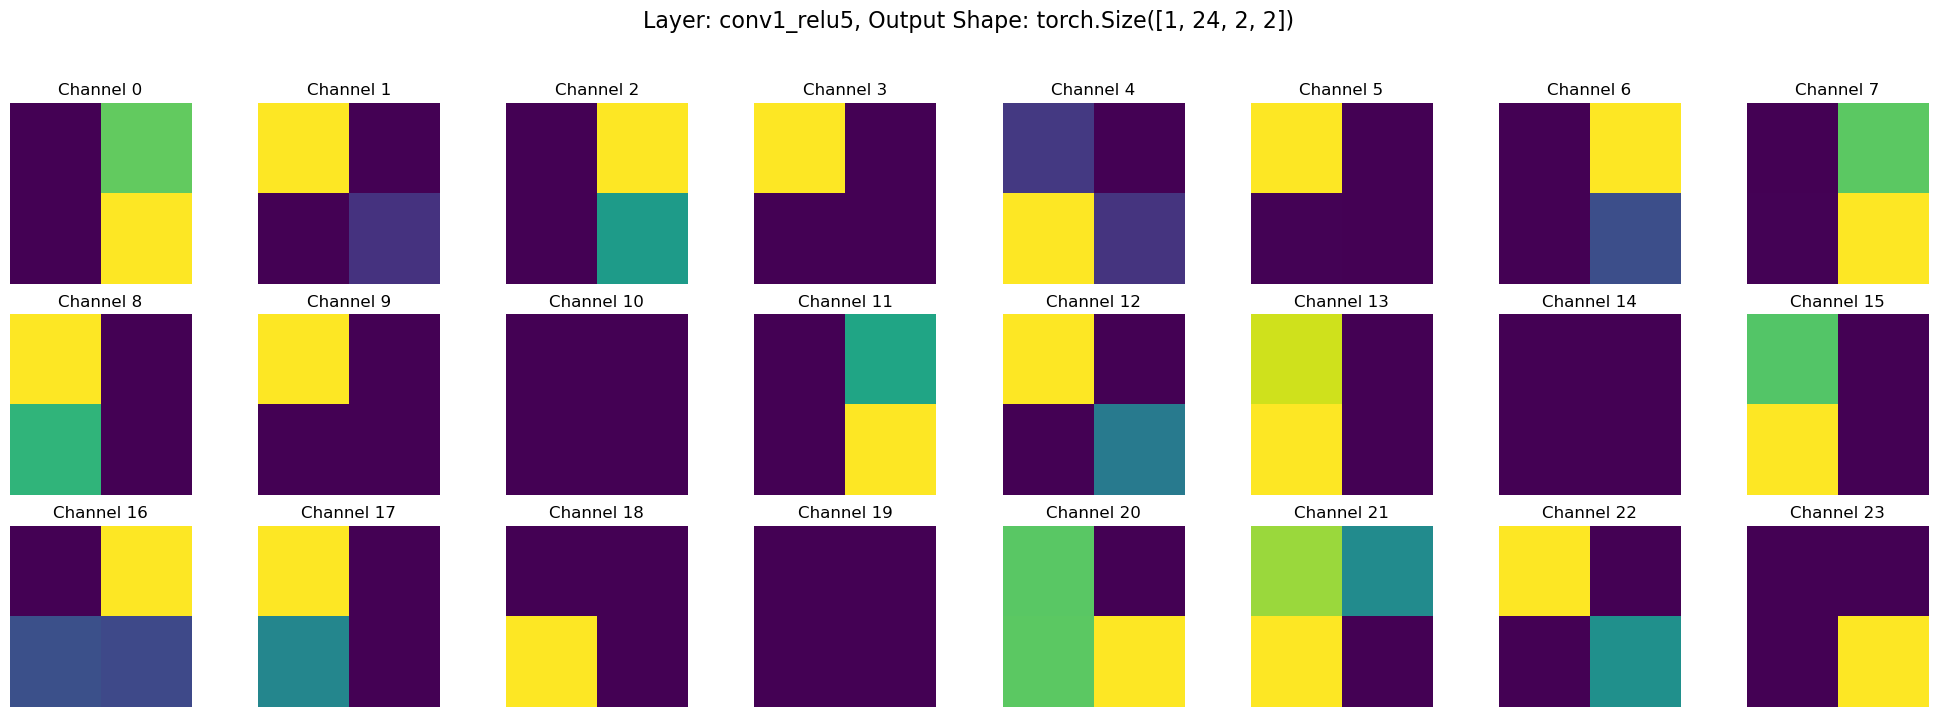

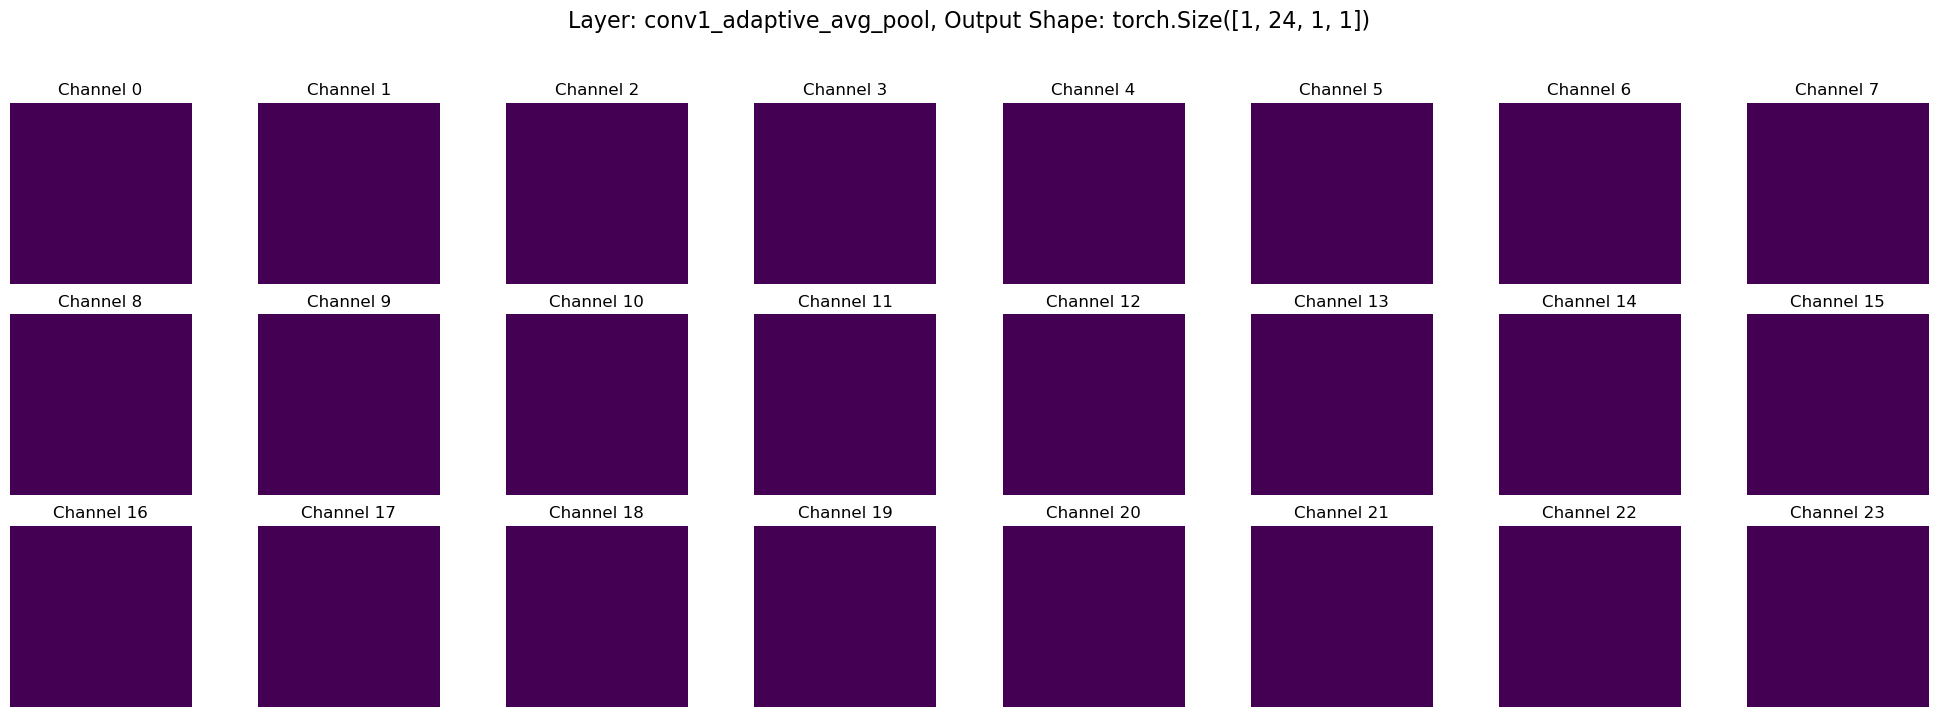

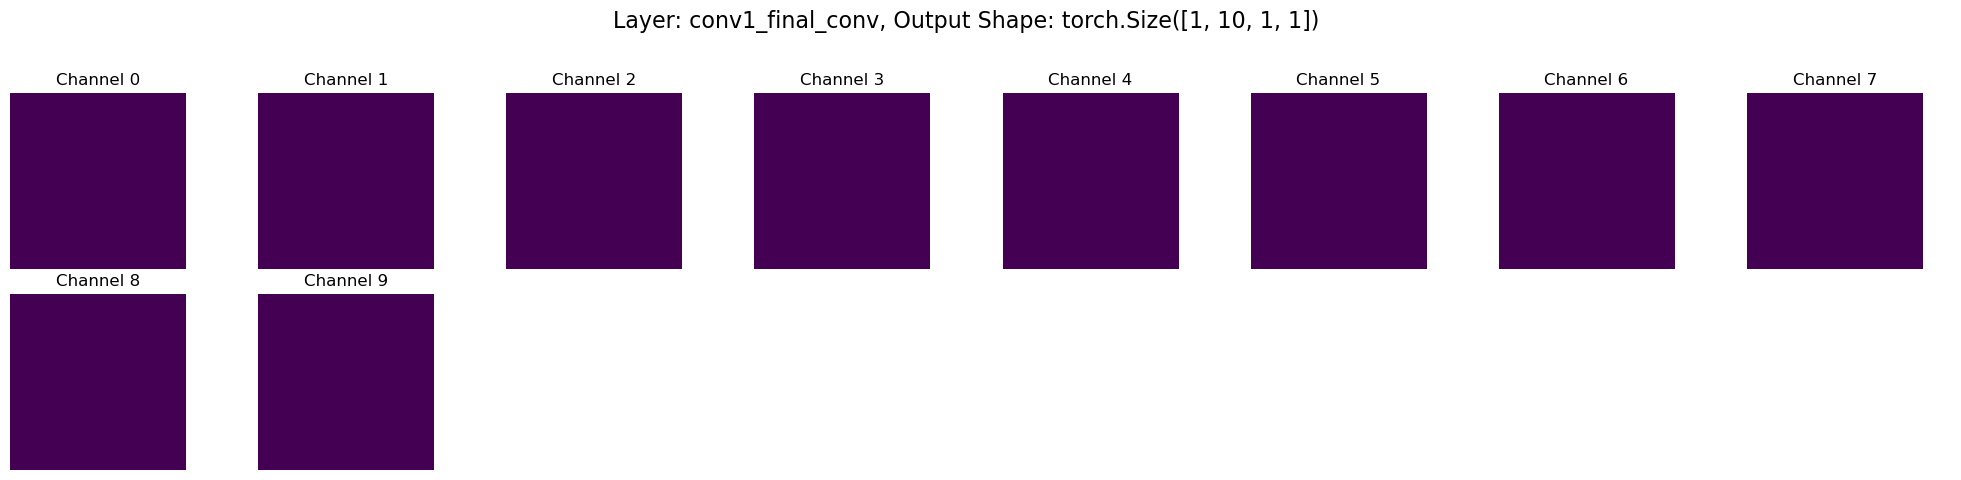

Visualization complete.


In [31]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Assuming MNISTModelFinal is defined in model3.py
model = MNISTModelFinal()
# It's good practice to load trained weights if available, but for visualization of architecture, random weights are fine.
# If you have a checkpoint, you can load it:
# model.load_state_dict(torch.load('model3/mnist_model_checkpoint.pth')['model_state_dict'])
model.eval() # Set model to evaluation mode

# 2. Load a single image from the MNIST dataset
# We need to use the same transformations as during training, but for visualization of raw image, we'll get one without normalization first
transform_raw = transforms.Compose([
    transforms.ToTensor(),
])

transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset_raw = datasets.MNIST(root='./data', train=False, download=True, transform=transform_raw)
test_dataset_normalized = datasets.MNIST(root='./data', train=False, download=True, transform=transform_normalized)

# Select a single image
image_raw, label = test_dataset_raw[2] # Get the first image and its label
image_normalized, _ = test_dataset_normalized[2] # Get the normalized version

print(f"Original image shape: {image_raw.shape}, Label: {label}")

# Add a batch dimension
image_normalized = image_normalized.unsqueeze(0) # Shape: [1, 1, 28, 28]

# 3. Implement forward hooks to capture outputs from each significant layer
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks for the layers within the conv1 sequential block
# The sequential block is at model.conv1
# Accessing individual modules in nn.Sequential: model.conv1[idx]

# I will choose to hook after each ReLU and MaxPool2d to see the feature evolution.
# Looking at model3.py lines:
# 15: self.conv1 = nn.Sequential(
# 17:    nn.Conv2d(1, 12, kernel_size=3, padding='same', bias=False),
# 18:    nn.BatchNorm2d(12),
# 19:    nn.ReLU(inplace=True), # Hook 1 (idx 2) - after first conv block
# 23:    nn.Conv2d(12, 12, kernel_size=3, padding='same', groups=1, bias=False),
# 24:    nn.BatchNorm2d(12),
# 25:    nn.ReLU(inplace=True), # Hook 2 (idx 5) - after second conv block
# 28:    nn.MaxPool2d(kernel_size=2), # Hook 3 (idx 6) - after first maxpool
# 32:    nn.Conv2d(12, 12, kernel_size=3, padding='same', bias=False),
# 33:    nn.BatchNorm2d(12),
# 34:    nn.ReLU(inplace=True), # Hook 4 (idx 9) - after third conv block
# 38:    nn.Conv2d(12, 12, kernel_size=3, padding='same', bias=False),
# 39:    nn.BatchNorm2d(12),
# 40:    nn.ReLU(inplace=True), # Hook 5 (idx 12) - after fourth conv block
# 43:    nn.MaxPool2d(kernel_size=2), # Hook 6 (idx 13) - after second maxpool
# 46:    nn.Conv2d(12, 24, kernel_size=3, groups=4, bias=False),
# 47:    nn.BatchNorm2d(24),
# 48:    nn.ReLU(inplace=True), # Hook 7 (idx 16) - after fifth conv block
# 51:    nn.AdaptiveAvgPool2d(1), # Hook 8 (idx 17) - after adaptive avg pool
# 54:    nn.Conv2d(24, 10, kernel_size=1, bias=False), # Hook 9 (idx 18) - after final 1x1 conv
# )

model.conv1[2].register_forward_hook(get_activation('conv1_relu1'))
model.conv1[5].register_forward_hook(get_activation('conv1_relu2'))
model.conv1[6].register_forward_hook(get_activation('conv1_maxpool1'))
model.conv1[9].register_forward_hook(get_activation('conv1_relu3'))
model.conv1[12].register_forward_hook(get_activation('conv1_relu4'))
model.conv1[13].register_forward_hook(get_activation('conv1_maxpool2'))
model.conv1[16].register_forward_hook(get_activation('conv1_relu5'))
model.conv1[17].register_forward_hook(get_activation('conv1_adaptive_avg_pool'))
model.conv1[18].register_forward_hook(get_activation('conv1_final_conv'))


# 4. Perform a forward pass on the selected image
with torch.no_grad():
    output = model(image_normalized)

# 5. Plot the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, len(activations) + 1, 1) # +1 for the original image
plt.imshow(image_raw.squeeze().numpy(), cmap='gray')
plt.title(f"Original Image (Label: {label})")
plt.axis('off')

# 6. Plot the feature maps (channels) from selected layers
# I will plot a subset of channels for each layer to avoid too many plots.
# If a layer has many channels, I'll plot the first 8 or so.

plot_idx = 2
for name, activation in activations.items():
    if activation.dim() == 4: # Convolutional/Pooling layers output 4D tensors (batch, channels, height, width)
        num_channels = activation.shape[1]
        # Determine grid dimensions for plotting
        num_cols = 8  # Number of columns for displaying channels
        num_rows = (num_channels + num_cols - 1) // num_cols # Ceiling division

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.5, num_rows * 2.5))
        fig.suptitle(f"Layer: {name}, Output Shape: {activation.shape}", fontsize=16)
        axs = axs.flatten() # Flatten the 2D array of axes for easy iteration

        for i in range(num_channels):
            ax = axs[i]
            channel_data = activation[0, i].cpu().numpy()
            ax.imshow(channel_data, cmap='viridis')
            ax.set_title(f"Channel {i}")
            ax.axis('off')

        # Turn off any unused subplots
        for i in range(num_channels, num_rows * num_cols):
            axs[i].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif activation.dim() == 2: # Fully connected/output layer
        # For the final 1x1 conv output (logits), it's a 1x10 tensor.
        # We can visualize it as a bar chart or simply print.
        print(f"Layer: {name}, Output Shape: {activation.shape}")
        print(f"Logits: {activation.squeeze().cpu().numpy()}")
        plt.figure(figsize=(8, 2))
        plt.bar(range(activation.shape[1]), activation.squeeze().cpu().numpy())
        plt.title(f"Layer: {name} (Logits)")
        plt.xlabel("Class")
        plt.ylabel("Value")
        plt.xticks(range(activation.shape[1]))
        plt.show()

print("Visualization complete.")

